## imports

In [1]:
import os
import sys

import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

sys.path.append(os.path.abspath(r'../../'))

from src.utils.common import get_model_resnet18_cifar10, get_loader, create_saved_data_dir, get_device, save, load
from src.utils.dataset import get_cifar10
from src.utils.plot import plot_prune_example, plot_loss_acc
from src.utils.train import Mode, run_epoch, train, ModelManager, Mode

# globals
NUM_CLASSES = 10
BATCH_SIZE = 25
NUM_TRAIN = 50000
# NUM_VALID = 10000
NUM_TEST = 10000
PRUNE_EPOCHS = 10
EPOCHS = 40

DEVICE = get_device()
# PATH_MODELS_SAVE = create_saved_data_dir(os.path.join(os.path.abspath(''), 'research', 'el2n_resnet18_cifar10.ipynb'))

# data loaders, models
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
data_train, data_test = get_cifar10(os.path.abspath(os.path.join('../../../', 'datasets')))
loader_train = get_loader(data_train, np.arange(NUM_TRAIN), BATCH_SIZE)
loader_train_ordered = get_loader(data_train, np.arange(NUM_TRAIN), BATCH_SIZE, shuffle=False)
# loader_valid = get_loader(data_train, np.arange(NUM_TRAIN, NUM_VALID + NUM_TRAIN), BATCH_SIZE)
loader_test = get_loader(data_test, np.arange(NUM_TEST), BATCH_SIZE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
epochs_pred = torch.empty((PRUNE_EPOCHS, NUM_TRAIN), dtype=torch.int8)
change_counter = torch.zeros(NUM_TRAIN, dtype=torch.int8)

model_manager = ModelManager('forgetting')
print()
loss_train, loss_valid, acc_train, acc_valid = [], [], [], []
for epoch in range(PRUNE_EPOCHS):
    train_res = model_manager.run_epoch(loader_train, Mode.TRAIN)
    valid_res = model_manager.run_epoch(loader_test, Mode.VALIDATE)
    loss_train.append(train_res[2]), loss_valid.append(valid_res[2])
    acc_train.append(train_res[3]), acc_valid.append(valid_res[3])
    print(f'Epoch: {epoch} Training: Loss: {loss_train[-1]:.6f} Acc: {acc_train[-1]:.6f}  '
          f'Validation Loss: {loss_valid[-1]:.6f} Acc: {acc_valid[-1]:.6f}  ', end='')

    train_res = model_manager.run_epoch(loader_train_ordered, Mode.TEST)
    epochs_pred[epoch] = train_res[1].detach().clone()
    if epoch:
        changes = torch.Tensor(epochs_pred[epoch - 1] != epochs_pred[epoch])
        changes_mean = changes.type(torch.float64).mean()
        print(f'Changes {changes_mean * 100:.03}%')
        model_manager.tb.add_scalar('changes_mean', changes_mean, epoch)
        change_counter += changes
    else:
        print()

    model_manager.scheduler.step()

model_manager.save_model()
model_manager.save_data()
model_manager.save_other({'epochs_pred': epochs_pred, 'change_counter': change_counter})


Epoch: 0 Training: Loss: 0.013641 Acc: 0.508940  Validation Loss: 0.011186 Acc: 0.596200  
Epoch: 1 Training: Loss: 0.008962 Acc: 0.681780  Validation Loss: 0.010177 Acc: 0.642300  Changes 26.6%
Epoch: 2 Training: Loss: 0.005857 Acc: 0.797660  Validation Loss: 0.010950 Acc: 0.636800  Changes 20.8%
Epoch: 3 Training: Loss: 0.003073 Acc: 0.897820  Validation Loss: 0.011887 Acc: 0.648200  Changes 11.9%
Epoch: 4 Training: Loss: 0.001528 Acc: 0.951560  Validation Loss: 0.013703 Acc: 0.640200  Changes 6.91%
Epoch: 5 Training: Loss: 0.001043 Acc: 0.965840  Validation Loss: 0.015535 Acc: 0.637600  Changes 5.79%
Epoch: 6 Training: Loss: 0.000890 Acc: 0.970160  Validation Loss: 0.015161 Acc: 0.655500  Changes 4.85%
Epoch: 7 Training: Loss: 0.000854 Acc: 0.971020  Validation Loss: 0.015494 Acc: 0.654600  Changes 3.17%
Epoch: 8 Training: Loss: 0.000747 Acc: 0.974540  Validation Loss: 0.016072 Acc: 0.653600  Changes 2.93%
Epoch: 9 Training: Loss: 0.000720 Acc: 0.975380  Validation Loss: 0.016101 A

## Plot histogram of changes for each train example

In [3]:
model_manager = ModelManager('forgetting', load=True)
change_counter = model_manager.data_other['change_counter']
epochs_pred = model_manager.data_other['epochs_pred']

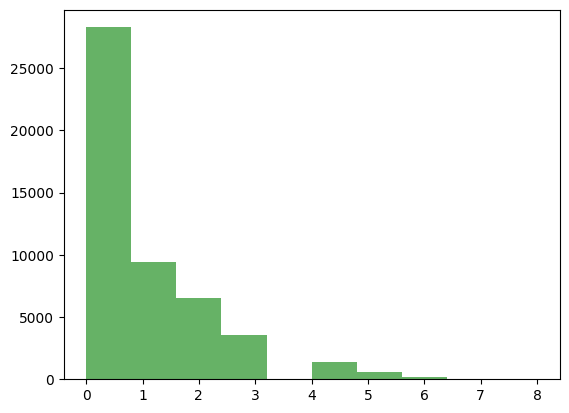

In [4]:
plt.hist(change_counter, bins=PRUNE_EPOCHS, facecolor='g', alpha=0.6)
plt.show()

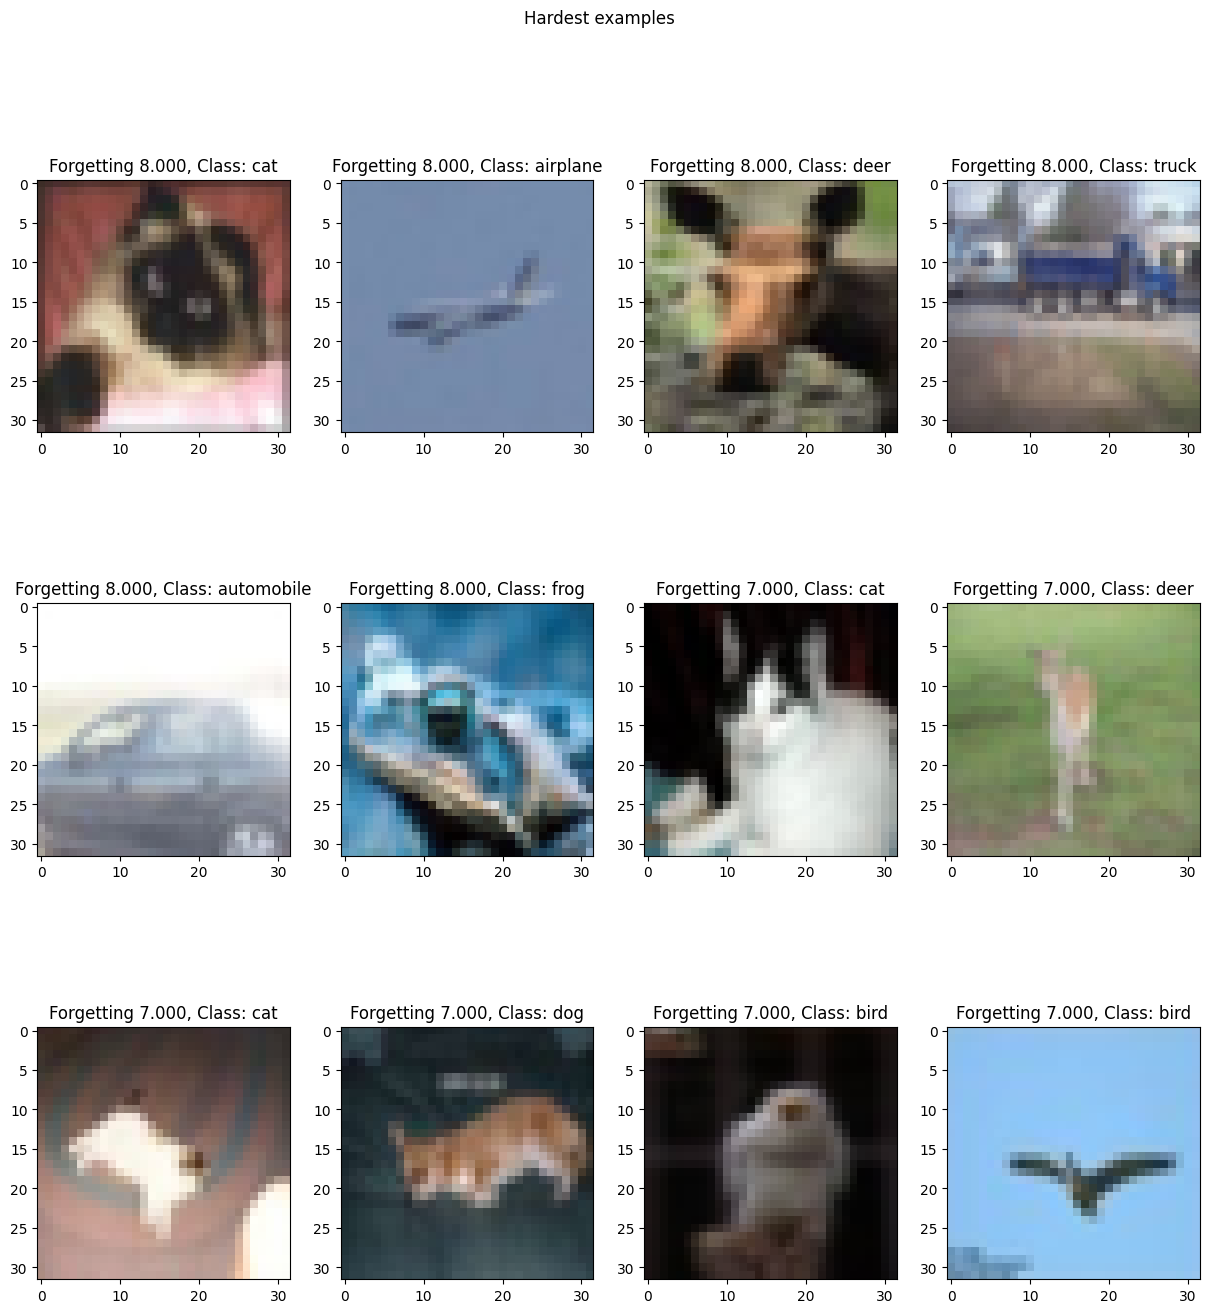

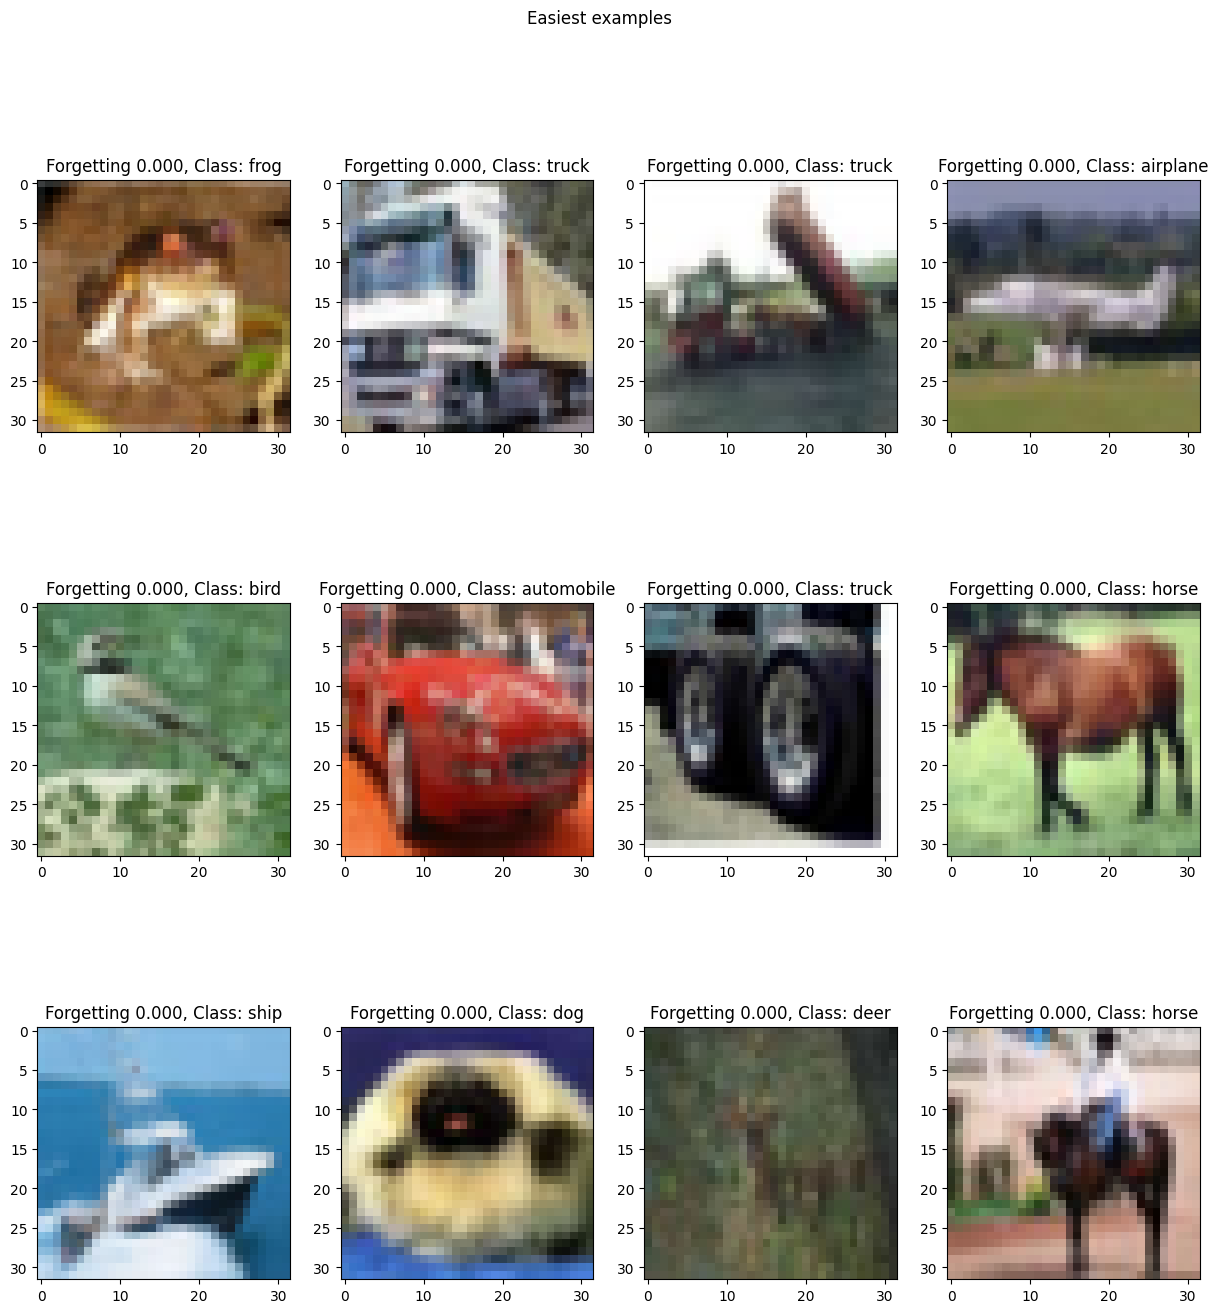

In [5]:
data_train_raw = torchvision.datasets.CIFAR10(os.path.abspath(r'../../../datasets'), train=True)
plot_prune_example(data_train_raw, change_counter, hardest=True, random=False, prune_method_name='Forgetting')
plot_prune_example(data_train_raw, change_counter, hardest=False, random=False, prune_method_name='Forgetting')

In [6]:
# model, criterion, optimizer, scheduler = get_model_resnet18_cifar10()
#
# print()
# loss_train, loss_valid, acc_train, acc_valid = [], [], [], []
# for epoch in range(PRUNE_EPOCHS):
#     train_res = run_epoch(model, criterion, optimizer, loader_train, NUM_CLASSES, DEVICE, Mode.TRAIN)
#     valid_res = run_epoch(model, criterion, optimizer, loader_test, NUM_CLASSES, DEVICE, Mode.VALIDATE)
#     loss_train.append(train_res[2]), loss_valid.append(valid_res[2])
#     acc_train.append(train_res[3]), acc_valid.append(valid_res[3])
#     print(f'Epoch: {epoch} Training: Loss: {loss_train[-1]:.6f} Acc: {acc_train[-1]:.6f}  '
#           f'Validation Loss: {loss_valid[-1]:.6f} Acc: {acc_valid[-1]:.6f}  ', end='')
#
#     train_res = run_epoch(model, criterion, optimizer, loader_train_ordered, NUM_CLASSES, DEVICE, Mode.TEST)
#     epochs_pred[epoch] = train_res[1].detach().clone()
#     if epoch:
#         changes = torch.Tensor(epochs_pred[epoch - 1] != epochs_pred[epoch])
#         print(f'Changes {changes.type(torch.float64).mean()}')
#         change_counter += changes
#     else:
#         print()
#
#     scheduler.step()
#
# data = load(PATH_MODELS_SAVE(''))
# model = get_model_resnet18_cifar10()[0].load_state_dict(data['model'])
# epochs_pred, change_counter = data['epochs_pred'], data['change_counter']
# loss_train, loss_valid = data['loss_train'], data['loss_valid']
# acc_train, acc_valid = data['acc_train'], data['acc_valid']